# Histopathologic Cancer Detection

This initiative aims to engineer an algorithm capable of pinpointing metastatic cancer within small fragments of extensive digital pathology scans. Initially, we will delve into analyzing the dataset provided for this competition, to comprehensively understand it. Our strategy encompasses the deployment of three distinct convolutional neural network (CNN) models. These models are tasked with discerning between cancerous (labelled as 1) and non-cancerous cells (labelled as 0). Among these, the third model leverages transfer learning, employing a pre-trained network to enhance our capability in accurately classifying the cells. This approach not only promises to refine the precision of cancer detection but also accelerates the timeframe within which patients can begin receiving critical treatments. We plan to construct two models from scratch—one without hyperparameter adjustments and another with fine-tuned hyperparameters. Additionally, the use of a pre-trained model introduces transfer learning into our methodology, potentially boosting our model's performance. In the final phase, we will evaluate our models and propose recommendations for further enhancing their effectiveness in future research endeavors.

In [1]:
import numpy as np 
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import AvgPool2D,BatchNormalization, Conv2D, Dense, Flatten, Input, GlobalAveragePooling2D, Dropout 
from keras.layers import MaxPool2D, MaxPooling2D, ReLU, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import math, gc, copy
AUTOTUNE = tf.data.AUTOTUNE
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

print("TensorFlow version:", tf.__version__)
print("TensorFlow I/O version:", tfio.__version__)

2024-04-05 22:43:23.243427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 22:43:23.243556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 22:43:23.367178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0
TensorFlow I/O version: 0.35.0


Let's load the data.

In [2]:
train_path = '../input/histopathologic-cancer-detection/train/'
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(df.info())
print('')

print(df.describe())
print('')

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None

               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000



,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


# **Exploratory Data Analysis**

We have already loaded the data. Now, we will try to characterize the data and run some visualizations. We will also try to develop the modeling strategy after looking at our data.

label
0    130908
1     89117
Name: count, dtype: int64


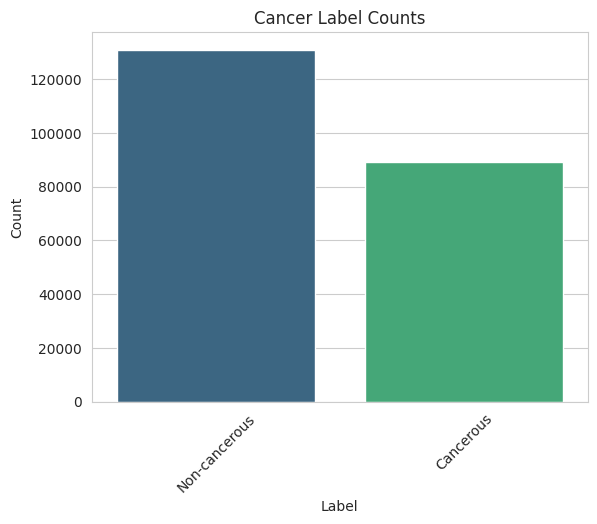

In [3]:
sns.set_style("whitegrid")
print(df['label'].value_counts())
df['label_readable'] = df['label'].replace({0: 'Non-cancerous', 1: 'Cancerous'})
sns.countplot(x=df['label_readable'], palette='viridis').set(title='Cancer Label Counts')

plt.xlabel('Label')  
plt.ylabel('Count')
plt.xticks(rotation=45)  

plt.show()

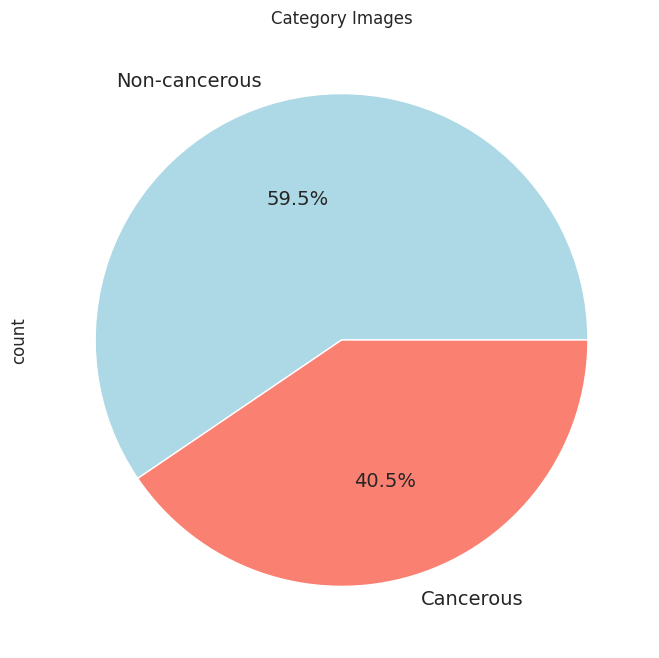

In [4]:

sns.set(style='whitegrid')

#df['label'] = df['label'].replace(0, 'Non-cancerous').replace(1, 'Cancerous')

pie_chart = df['label_readable'].value_counts()

colors = ['lightblue', 'salmon']  # Example colors

pie_chart.plot(kind='pie', 
               title='Category Images',
               autopct='%1.1f%%',  # Show percentage
               shadow=False, 
               labels=pie_chart.index,  # Use the index as labels
               legend = False, 
               fontsize=14, 
               figsize=(18,8),
               colors=colors)  # Apply the custom colors here

# Display the plot
plt.show()

Currently, our dataset comprises approximately 40% cancerous and 60% non-cancerous data, indicating an imbalance. Although not perfectly balanced, I've decided not to adjust this ratio before initiating model training.

Furthermore, the dataset appears to be clean, eliminating the need for any data cleaning processes.

To visualize the difference between cancerous and non-cancerous images, we can create a plot that displays a few examples of each. This visual comparison can help us understand how distinct or similar they might appear, which is crucial for training our models effectively. Let's proceed by plotting a small set of both cancerous and non-cancerous images from your dataset.

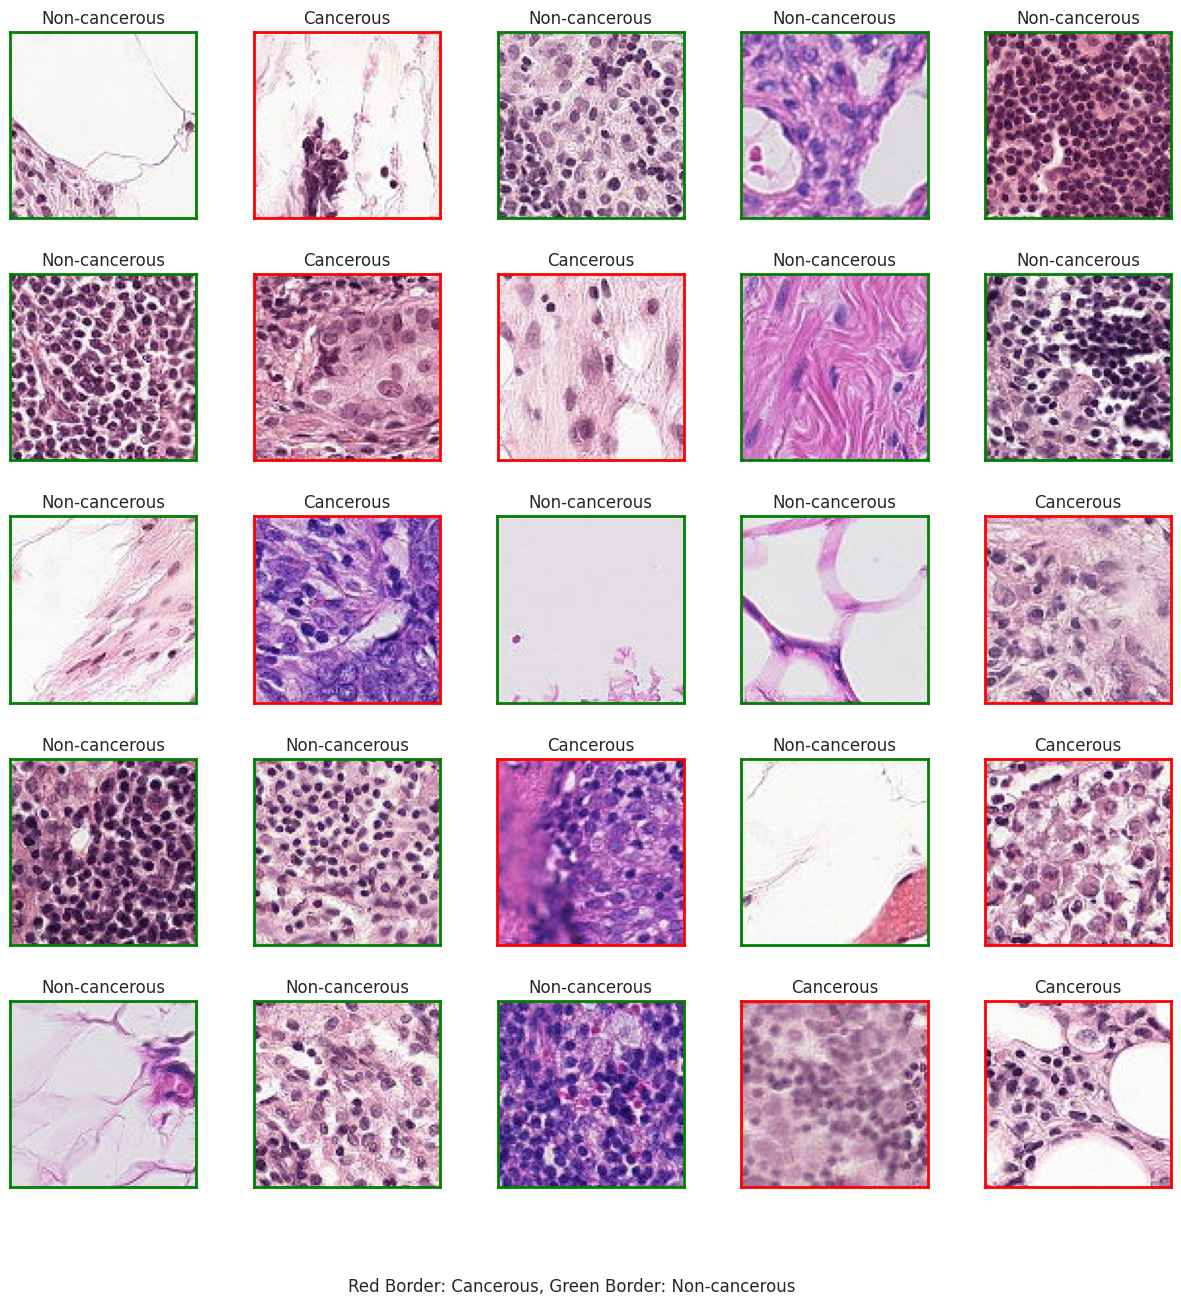

In [5]:
from skimage import io

fig, ax = plt.subplots(5, 5, figsize=(15, 15))

plt.subplots_adjust(hspace=0.3, wspace=0.3)

for i, axis in enumerate(ax.flat):
    file = str(train_path + df.id[i] + '.tif')
    
    image = io.imread(file)
    
    axis.imshow(image)
    
    axis.set_xticks([])
    axis.set_yticks([])
    
    label_text = 'Cancerous' if df.label[i] == 1 else 'Non-cancerous'
    axis.set_title(label_text)
    
    edge_color = 'red' if df.label[i] == 1 else 'green'
    for spine in axis.spines.values():  # Change the edge color of each subplot
        spine.set_edgecolor(edge_color)
        spine.set_linewidth(2)


fig.text(0.5, 0.04, 'Red Border: Cancerous, Green Border: Non-cancerous', ha='center', fontsize=12)

plt.show()

# Data Preprocessing

We can see that it's hard to distinguish between cancerous and non cancerous images without prior knowledge.

Now, we'll divide our dataset into training and validation subsets, adhering to the traditional 80% for training and 20% for validation split.

In [6]:
randomseed = 12

num_class1 = df.label.sum()
num_train_class1 = int(num_class1 * 0.8)
num_test_class1 = num_class1 - num_train_class1

print(f"Number of Class 1 Observations: {num_class1}")
print(f"Number of Class 1 Training Observations: {num_train_class1}")
print(f"Number of Class 1 Testing Observations: {num_test_class1}")

# Splitting the dataset based on the label
df_cancer = df[df['label'] == 1]
df_benign = df[df['label'] == 0]

train_cancer, test_cancer = train_test_split(df_cancer, test_size=num_test_class1, random_state=randomseed)
train_benign, test_benign = train_test_split(df_benign, test_size=num_test_class1, random_state=randomseed)

train_df = pd.concat([train_cancer, train_benign])
test_df = pd.concat([test_cancer, test_benign])

print(f"Length of Cancer Training Set: {len(train_cancer)}")
print(f"Length of Benign Training Set: {len(train_benign)}")
print(f"Length of Cancer Testing Set: {len(test_cancer)}")
print(f"Length of Benign Testing Set: {len(test_benign)}")

# Checks to ensure there's no overlap (should both output 0)
print(f"Number of Cancer rows in both Training and Testing Set: {pd.merge(train_cancer, test_cancer, how='inner').shape[0]}")
print(f"Number of Benign rows in both Training and Testing Set: {pd.merge(train_benign, test_benign, how='inner').shape[0]}")

Number of Class 1 Observations: 89117
Number of Class 1 Training Observations: 71293
Number of Class 1 Testing Observations: 17824
Length of Cancer Training Set: 71293
Length of Benign Training Set: 113084
Length of Cancer Testing Set: 17824
Length of Benign Testing Set: 17824
Number of Cancer rows in both Training and Testing Set: 0
Number of Benign rows in both Training and Testing Set: 0


Let's prepare our data to train our models.

In [7]:
def add_img_info(img_id):
    """
    Generate the full path for an image given its ID.
    
    Parameters:
    - img_id: The unique identifier for the image.
    
    Returns:
    - A string representing the full file path to the image.
    """
    return f"/kaggle/input/histopathologic-cancer-detection/train/{img_id}.tif"


trainlistc = train_cancer['id']
trainlistb = train_benign['id']
df_train_cancer = df.loc[df['id'].isin(trainlistc.tolist())]
df_train_benign = df.loc[df['id'].isin(trainlistb.tolist())]

# Concatenate the cancer and benign DataFrames, shuffle the combined DataFrame, and reset index
df_train = pd.concat([df_train_cancer, df_train_benign]).sample(frac=1, random_state=randomseed).reset_index(drop=True)

# Apply the add_img_info function to each ID to create the path column
df_train['path'] = df_train['id'].apply(add_img_info)

# Output the length and number of cancer observations
print(f"Length: {len(df_train['id'])}, Number of Cancer Observations: {df_train['label'].sum()}")

# Display the first few rows of the DataFrame
df_train.head()


Length: 184377, Number of Cancer Observations: 71293


,id,label,label_readable,path
0,d428f9f5105410b52c764a13fbb64aae1e8be20d,1,Cancerous,/kaggle/input/histopathologic-cancer-detection...
1,fd826aadf7a1f4e4a01d4be4c338b190f2ae5e39,0,Non-cancerous,/kaggle/input/histopathologic-cancer-detection...
2,ff216a3ed93f4682d5fed75d9cb849b311c051c5,1,Cancerous,/kaggle/input/histopathologic-cancer-detection...
3,7880f8ae560d4e12051b3597f944f94212deba9c,1,Cancerous,/kaggle/input/histopathologic-cancer-detection...
4,ead5897d7a0c934c4e9e555313cc2f3c34200dbd,0,Non-cancerous,/kaggle/input/histopathologic-cancer-detection...


In [8]:
testlistc = test_cancer['id']
testlistb = test_benign['id']
df_test_cancer = df.loc[df['id'].isin(testlistc.tolist())]
df_test_benign = df.loc[df['id'].isin(testlistb.tolist())]

df_test = pd.concat([df_test_cancer, df_test_benign]).sample(frac=1, random_state=randomseed).reset_index(drop=True)
df_test['path'] = df_test['id'].apply(add_img_info)

# Output the length and number of cancer observations
print(f"Length: {len(df_test['id'])}, Number of Cancer Observations: {df_test['label'].sum()}")

# Display the first few rows of the DataFrame
df_test.head()

Length: 35648, Number of Cancer Observations: 17824


,id,label,label_readable,path
0,44437fa3946f41fde764736dfda6646f61a2d604,1,Cancerous,/kaggle/input/histopathologic-cancer-detection...
1,85b3af29026fa6edd744f43420341d7dad2348a9,0,Non-cancerous,/kaggle/input/histopathologic-cancer-detection...
2,2998c1af1b0f3d6894d88df4632982a1d1cb7c26,1,Cancerous,/kaggle/input/histopathologic-cancer-detection...
3,b5879a2c737661bf3d80654e82d5d65fad22de7d,0,Non-cancerous,/kaggle/input/histopathologic-cancer-detection...
4,c5aead62c48fc5957bee1e5afc07182bc7713945,1,Cancerous,/kaggle/input/histopathologic-cancer-detection...


In [9]:
def add_images(path, img_size=(96, 96)):
    file = tf.io.read_file(path)
    img = tfio.experimental.image.decode_tiff(file, index=0)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = img[:, :, 0:-1]  # Assuming you want to remove the alpha channel if present
    img = tf.image.resize(img, img_size)  # Resize the image
    img = tf.cast(img, tf.float32) / 255.0  # Normalize pixels to 0-1
    return img

In [10]:
#trlabs = tf.data.Dataset.from_tensor_slices(tf.one_hot(df_train.label.values, depth=2))
#telabs = tf.data.Dataset.from_tensor_slices(tf.one_hot(df_test.label.values, depth=2))

trlabs = tf.data.Dataset.from_tensor_slices(df_train.label.values.astype(np.float32))
telabs = tf.data.Dataset.from_tensor_slices(df_test.label.values.astype(np.float32))

#trlabs = tf.data.Dataset.from_tensor_slices(np.array([np.array([0,1]) if i ==1 else np.array([1,0]) for i in df_train.label.values ]))
#telabs = tf.data.Dataset.from_tensor_slices(np.array([np.array([0,1]) if i ==1 else np.array([1,0]) for i in df_test.label.values ]))

AUTOTUNE = tf.data.experimental.AUTOTUNE

trpaths = tf.data.Dataset.from_tensor_slices(df_train.path.values)
tepaths = tf.data.Dataset.from_tensor_slices(df_test.path.values)

#trpaths = tf.data.Dataset.from_tensor_slices(np.array([path for path in df_train.path.values]))
#tepaths = tf.data.Dataset.from_tensor_slices(np.array([path for path in df_test.path.values]))

#trimgs = trpaths.map(add_images, num_parallel_calls=AUTOTUNE)
#teimgs = tepaths.map(add_images, num_parallel_calls=AUTOTUNE)

trimgs = trpaths.map(add_images)
teimgs = tepaths.map(add_images)

train_set = tf.data.Dataset.zip((trimgs, trlabs)).shuffle(buffer_size=1000).batch(64).prefetch(AUTOTUNE)
test_set = tf.data.Dataset.zip((teimgs, telabs)).batch(64).prefetch(AUTOTUNE)

#train_set = tf.data.Dataset.zip((trimgs,trlabs)).batch(64).prefetch(AUTOTUNE)
#test_set = tf.data.Dataset.zip((teimgs,telabs)).batch(64).prefetch(AUTOTUNE)

Let's see if we can get any TPUs to run our model.

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import AUC

# Detect and initialize the TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("Running on TPU:", tpu.master())
except ValueError:
    print("Could not connect to TPU")
    tpu_strategy = tf.distribute.get_strategy()  # Default strategy that works on CPU and single GPU

print("Number of replicas:", tpu_strategy.num_replicas_in_sync)


Could not connect to TPU
Number of replicas: 1


# Model Architecture Overview

I plan to construct two models from the ground up and incorporate one pre-trained model into our project. Additionally, I will implement checkpoints to ensure that we can always revert to the best-performing version of each model for our final analysis.

**Basic Model Design**

The structure begins with an input layer, followed by a convolutional layer, a max pooling layer, another convolutional layer, a second max pooling layer, a flattening step, a dense layer, and concludes with an output layer utilizing a sigmoid activation function.

**Enhanced Model Design**

This model starts with an input layer, then a convolutional layer, batch normalization, max pooling, dropout, another convolutional layer, batch normalization, max pooling, dropout, a third convolutional layer, batch normalization, max pooling, dropout, flattening, a dense layer, batch normalization, dropout, and finishes with an output layer that features sigmoid activation. I will initiate this model with an Adam optimizer and a learning rate of 0.000025.

**Transfer Learning Approach**

Here, I employ the ResNet50 as the pre-trained model. The architecture includes ResNet50, followed by global average pooling, a dense layer, batch normalization, dropout, and finally an output layer with sigmoid activation.

**Basic model**

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping



def build_basic_model(input_shape=(96, 96, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape), 
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'), 
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'), 
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    

    return model

with tpu_strategy.scope():
    model = build_basic_model(input_shape=(96, 96, 3))
    model.compile(
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(curve='ROC')]
    )
    model.summary()
    





Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,452,801 (9.36 MB)

 Trainable params: 2,452,801 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
initial_filepath = '/kaggle/working/base_model/'
!mkdir {initial_filepath}

#checkpoint_filepath = '/kaggle/working/advance_model/model_epoch{epoch:02d}_valAcc{val_accuracy:.4f}.keras'
checkpoint_filepath = '/kaggle/working/base_model/checkpoint.model.keras'
                                           
checkpoints = model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor="binary_crossentropy", 
                                             factor=.1,
                                             patience = 2,
                                             min_lr = 0)


In [14]:
# Train the model

#tf.config.optimizer.set_jit(True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_set,
                    validation_data=test_set,
                    epochs=10,
                   callbacks=[early_stopping,checkpoints,rlrop])

Epoch 1/10


2024-04-05 22:43:51.797822: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.35841, expected 3.49491
2024-04-05 22:43:51.797883: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 7.53323, expected 6.66972
2024-04-05 22:43:51.797892: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.8545, expected 5.99099
2024-04-05 22:43:51.797900: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.10056, expected 5.23705
2024-04-05 22:43:51.797908: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.77173, expected 4.90822
2024-04-05 22:43:51.797916: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.55641, expected 4.69291
2024-04-05 22:43:51.797923: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.70158, expected 5.83808
2024-04-05 22:43:51.797933: E external/local_xla/xla/ser

   1/2881 ━━━━━━━━━━━━━━━━━━━━ 9:55:16 12s/step - accuracy: 0.4531 - auc: 0.3764 - loss: 0.7056

I0000 00:00:1712357034.981540      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2878/2881 ━━━━━━━━━━━━━━━━━━━━ 2s 737ms/step - accuracy: 0.7551 - auc: 0.8111 - loss: 0.5153

2024-04-05 23:19:14.525873: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.56154, expected 3.06708
2024-04-05 23:19:14.525940: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.66309, expected 3.16863
2024-04-05 23:19:14.525956: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.88958, expected 3.39512
2024-04-05 23:19:14.525973: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 3.83471, expected 3.34025
2024-04-05 23:19:14.525985: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 3.85559, expected 3.36113
2024-04-05 23:19:14.525995: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.60675, expected 3.1123
2024-04-05 23:19:14.526006: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.66885, expected 3.17439
2024-04-05 23:19:14.526018: E external/local_xla/xla

2881/2881 ━━━━━━━━━━━━━━━━━━━━ 2549s 881ms/step - accuracy: 0.7551 - auc: 0.8112 - loss: 0.5152 - val_accuracy: 0.7138 - val_auc: 0.8198 - val_loss: 0.6086 - learning_rate: 0.0010
Epoch 2/10
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 429s 148ms/step - accuracy: 0.8431 - auc: 0.9102 - loss: 0.3678 - val_accuracy: 0.7790 - val_auc: 0.8741 - val_loss: 0.5438 - learning_rate: 0.0010
Epoch 3/10
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 361s 125ms/step - accuracy: 0.8661 - auc: 0.9299 - loss: 0.3253 - val_accuracy: 0.7860 - val_auc: 0.9038 - val_loss: 0.7553 - learning_rate: 0.0010
Epoch 4/10
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 367s 127ms/step - accuracy: 0.8768 - auc: 0.9401 - loss: 0.3025 - val_accuracy: 0.7726 - val_auc: 0.8583 - val_loss: 0.5509 - learning_rate: 0.0010
Epoch 5/10
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 361s 125ms/step - accuracy: 0.8851 - auc: 0.9456 - loss: 0.2885 - val_accuracy: 0.7400 - val_auc: 0.8641 - val_loss: 1.0912 - learning_rate: 0.0010
Epoch 6/10
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 362s 125ms/step - 

In [15]:
test_loss, test_acc, test_auc = model.evaluate(test_set)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}, Test ROC AUC: {test_auc}")

557/557 ━━━━━━━━━━━━━━━━━━━━ 59s 106ms/step - accuracy: 0.8157 - auc: 0.8896 - loss: 0.4869
Test Loss: 0.48355865478515625, Test Accuracy: 0.8158943057060242, Test ROC AUC: 0.8902222514152527


In [16]:
print(history.history.keys())

dict_keys(['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss', 'learning_rate'])


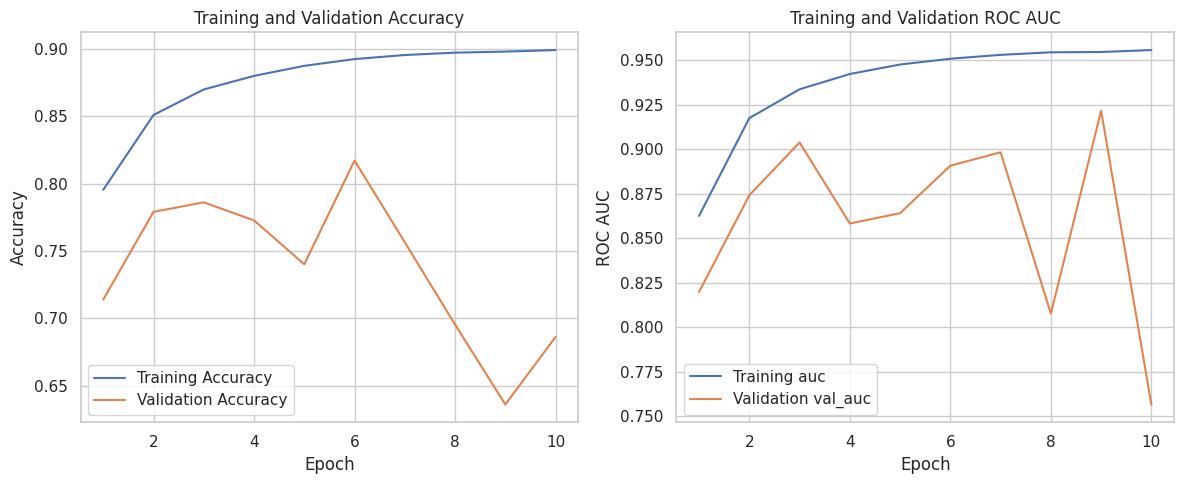

In [17]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    epochs = range(1, len(history.epoch) + 1)
    
    # Dynamically find the keys for the AUC metrics
    auc_keys = [key for key in history.history.keys() if "auc" in key and not key.startswith("val_")]
    val_auc_keys = [key for key in history.history.keys() if "val_auc" in key]
    
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot AUC
    if auc_keys and val_auc_keys:  # Check if AUC keys were found
        plt.subplot(1, 2, 2)
        for auc_key in auc_keys:
            plt.plot(epochs, history.history[auc_key], label=f'Training {auc_key}')
        for val_auc_key in val_auc_keys:
            plt.plot(epochs, history.history[val_auc_key], label=f'Validation {val_auc_key}')
        plt.title('Training and Validation ROC AUC')
        plt.xlabel('Epoch')
        plt.ylabel('ROC AUC')
        plt.legend()
    else:
        print("AUC metrics not found in history.")
    
    plt.tight_layout()
    plt.show()

plot_metrics(history)


**Enhanced model**

In [18]:
from tensorflow.keras import layers, models, optimizers

def build_advanced_model(input_shape=(96, 96, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Slower learning rate for the Adam optimizer
    optimizer = optimizers.Adam(learning_rate=0.001)
    with tpu_strategy.scope():
        model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC')])
        return model


In [19]:
initial_filepath = '/kaggle/working/advance_model/'
!mkdir {initial_filepath}

#checkpoint_filepath = '/kaggle/working/advance_model/model_epoch{epoch:02d}_valAcc{val_accuracy:.4f}.keras'
checkpoint_filepath = '/kaggle/working/advance_model/checkpoint.model.keras'
#!mkdir {checkpoint_filepath}
                                           
checkpoints = model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor="binary_crossentropy", 
                                             factor=.1,
                                             patience = 2,
                                             min_lr = 0)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

#with tpu_strategy.scope():
model2 = build_advanced_model()

model2.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history2 = model2.fit(
    train_set,
    validation_data=test_set,
    epochs=30, 
    callbacks=[early_stopping,checkpoints,rlrop]
    )



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,454,209 (9.36 MB)

 Trainable params: 2,453,505 (9.36 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/30
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 389s 131ms/step - accuracy: 0.8015 - auc_1: 0.8662 - loss: 0.4480 - val_accuracy: 0.8139 - val_auc_1: 0.9117 - val_loss: 0.4170 - learning_rate: 0.0010
Epoch 2/30
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 369s 127ms/step - accuracy: 0.8469 - auc_1: 0.9147 - loss: 0.3575 - val_accuracy: 0.6963 - val_auc_1: 0.7847 - val_loss: 0.7810 - learning_rate: 0.0010
Epoch 3/30
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 370s 128ms/step - accuracy: 0.8615 - auc_1: 0.9279 - loss: 0.3306 - val_accuracy: 0.8188 - val_auc_1: 0.9086 - val_loss: 0.4083 - learning_rate: 0.0010
Epoch 4/30
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 375s 130ms/step - accuracy: 0.8725 - auc_1: 0.9369 - loss: 0.3094 - val_accuracy: 0.6943 - val_auc_1: 0.7598 - val_loss: 0.7562 - learning_rate: 0.0010
Epoch 5/30
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 362s 125ms/step - accuracy: 0.8798 - auc_1: 0.9442 - loss: 0.2908 - val_accuracy: 0.7891 - val_auc_1: 0.8787 - val_loss: 0.4520 - learning_rate: 0.0010
Epoch 6/30
2881/2881 ━━━━━━━━━

dict_keys(['accuracy', 'auc_1', 'loss', 'val_accuracy', 'val_auc_1', 'val_loss', 'learning_rate'])


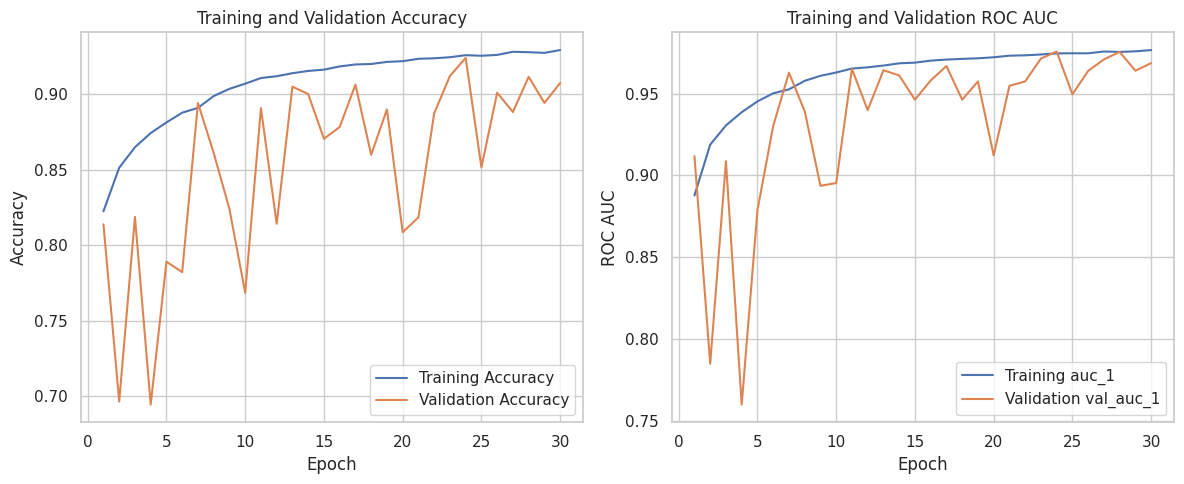

In [21]:
print(history2.history.keys())
plot_metrics(history2)

**Transfer learning model**

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


def build_transfer_learning_model(input_shape=(96, 96, 3)):
    # Load the pre-trained model, excluding its top fully connected layers
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Custom layers atop the pre-trained model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification layer
    ])
    
    return model

In [23]:
with tpu_strategy.scope():  # Use this if you're leveraging a TPU
    model3 = build_transfer_learning_model()
    model3.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC')])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [24]:
initial_filepath = '/kaggle/working/transfer_model/'
!mkdir {initial_filepath}

#checkpoint_filepath = '/kaggle/working/advance_model/model_epoch{epoch:02d}_valAcc{val_accuracy:.4f}.keras'
checkpoint_filepath = '/kaggle/working/transfer_model/checkpoint.model.keras'
                                           
checkpoints = model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
#checkpoint_filepath = '/kaggle/working/advanced_model/best_model.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max')

In [25]:
history_transfer = model3.fit(train_set,
                    validation_data=test_set,
                    epochs=10,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/10
   3/2881 ━━━━━━━━━━━━━━━━━━━━ 3:22 70ms/step - accuracy: 0.5738 - auc_2: 0.6305 - loss: 0.6949   

W0000 00:00:1712374901.853848      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2881/2881 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7039 - auc_2: 0.7590 - loss: 0.5666

W0000 00:00:1712375261.533119      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2881/2881 ━━━━━━━━━━━━━━━━━━━━ 437s 146ms/step - accuracy: 0.7039 - auc_2: 0.7590 - loss: 0.5666 - val_accuracy: 0.5051 - val_auc_2: 0.7924 - val_loss: 0.9777 - learning_rate: 0.0010
Epoch 2/10
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 375s 130ms/step - accuracy: 0.7237 - auc_2: 0.7829 - loss: 0.5440 - val_accuracy: 0.5959 - val_auc_2: 0.7951 - val_loss: 0.8108 - learning_rate: 0.0010
Epoch 3/10
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 388s 134ms/step - accuracy: 0.7267 - auc_2: 0.7854 - loss: 0.5414 - val_accuracy: 0.5729 - val_auc_2: 0.7946 - val_loss: 0.8981 - learning_rate: 0.0010
Epoch 4/10
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 403s 139ms/step - accuracy: 0.7283 - auc_2: 0.7877 - loss: 0.5395 - val_accuracy: 0.5955 - val_auc_2: 0.7938 - val_loss: 0.7050 - learning_rate: 0.0010
Epoch 5/10
2881/2881 ━━━━━━━━━━━━━━━━━━━━ 418s 144ms/step - accuracy: 0.7265 - auc_2: 0.7878 - loss: 0.5388 - val_accuracy: 0.7207 - val_auc_2: 0.7939 - val_loss: 0.5579 - learning_rate: 0.0010
Epoch 6/10
2881/2881 ━━━━━━━━━━━━━━━━━━━━

dict_keys(['accuracy', 'auc_2', 'loss', 'val_accuracy', 'val_auc_2', 'val_loss', 'learning_rate'])


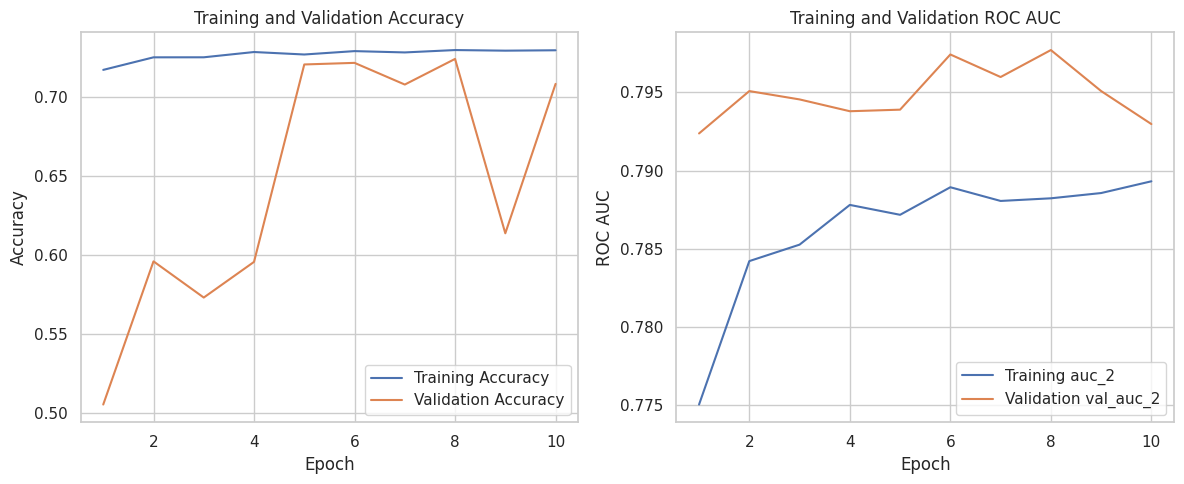

In [26]:
print(history_transfer.history.keys())
plot_metrics(history_transfer)

Let's finalize our submission by employing our top-performing model, the Enhanced model. It has outperformed both the Basic and Transfer Learning models, making it our best choice for the final analysis.

In [27]:
# Load the data into a dataframe for testing and submission
submit_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')

print(submit_df.info())
print('')

val = np.array(['/kaggle/input/histopathologic-cancer-detection/test/'+i+'.tif' for i in submit_df.id.values])  

vapaths = tf.data.Dataset.from_tensor_slices(val)
vaimgs = vapaths.map(add_images).batch(64).prefetch(AUTOTUNE)


model_best = tf.keras.models.load_model('/kaggle/working/advance_model/checkpoint.model.keras')
    
    

predsraw = model_best.predict(vaimgs)
preds = [np.argmax(x) for x in predsraw]
submit_df.label = preds
submit_df.to_csv('submission.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB
None

897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step

2024-04-06 05:03:18.698607: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.22034, expected 3.61501
2024-04-06 05:03:18.698668: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.20513, expected 3.59979
2024-04-06 05:03:18.698688: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 4.20631, expected 3.60097
2024-04-06 05:03:18.698702: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.81413, expected 4.2088
2024-04-06 05:03:18.698712: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 4.66988, expected 4.06455
2024-04-06 05:03:18.698723: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 4.60628, expected 4.00095
2024-04-06 05:03:18.698734: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 4.96641, expected 4.36108
2024-04-06 05:03:18.698744: E external/local_xla/xl

898/898 ━━━━━━━━━━━━━━━━━━━━ 715s 795ms/step


In [28]:
!head submission.csv 

id,label
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
2c35657e312966e9294eac6841726ff3a748febf,0
145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,0
aa0307865281d4484ddf8c637c348292968b93a7,0
f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,0
95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0


# Results

Among the three models we tested, the Enhanced model, with its hyperparameter tuning and optimization, emerged as the most effective. The Basic model achieved a maximum validation accuracy of 0.81, while the Enhanced model reached 0.92, and the Transfer Learning model lagged behind with a maximum of 0.72. Additionally, we plotted the Area Under the Curve (AUC) for all models, observing a consistent increase in training accuracy across the board. However, the validation accuracy exhibited a fluctuating, zigzag pattern. This indicated that, after a certain point, the models began to overfit, with validation accuracy subsequently declining. Nonetheless, by utilizing checkpoints, we were able to preserve the state of the model at its highest validation accuracy. Contrary to expectations, the Transfer Learning model underperformed, ranking as the least effective of the three. Ultimately, I applied the most successful model to the test data and made a submission to Kaggle, only to find that the competition had already concluded.

# Conclusion

I believe there's room for further enhancement in our models. Experimenting with various optimizers and incorporating additional layers could potentially lead to higher accuracy and better loss metrics. Despite the Enhanced model's superior performance, the Adam optimizer didn't deliver as effectively as anticipated. Exploring different pre-trained models for transfer learning might also yield improved results.

A significant amount of time was inadvertently spent running models on a CPU, which I later discovered was suboptimal for deep learning tasks. I was unaware that Kaggle offers GPU resources for users who verify their accounts with a phone number. Given that my models were timing out after 12 hours, it's clear that CPUs are ill-suited for the demands of deep learning models.

In summary, models have proven to be exceptionally capable in the realm of image recognition, yet there remains a vast potential for further refining their accuracy and efficiency.